# Noise in Phase Field Models
## Vera Titze Undergraduate Research Report Spring 2019

## I. Brownian Motion and Langevin Equations

The fluctuation dissipation theorem states that the expected noise $\eta$ in the phase field and in the concentration behave according to the following equations:
$$\left\langle\eta_{\psi}(\vec{x}, t) \eta_{\psi}(\vec{x}', t')\right\rangle= 2 \Gamma_{\psi} k_{b} T \delta(\vec{x}-\vec{x}') \delta(t-t')$$
$$\left\langle\eta_{c}(\vec{x}, t) \eta_{c}(\vec{x}', t')\right\rangle=2 \Gamma_{c} k_{b} T \nabla^{2} \delta(\vec{x}-\vec{x}') \delta(t-t')$$
Since $\left\langle\eta_{\psi}(\vec{x}, t)\right\rangle=0$ and $\left\langle\eta_{c}(\vec{x}, t)\right\rangle=0$ from the assumption that the statistical distribution of motion is centered about zero, the standard deviation of each noise term is equal to the square root RHS in each of the above equations. This follows from the general formula of the standard deviation:
$$\sigma^2=var(x)=\left\langle x^2\right\rangle-\left\langle x\right\rangle^2$$ for the case when $\vec{x}=\vec{x}'$ and $t=t'$, equivalent to one specific cell at one single timestep, independent of the cells around and the previous timestep.
Kosterlitz and Grant [1] proceed to add this noise term outside the functional:
$$ \frac{\partial \psi}{\partial t}=-\Gamma_{\psi} \frac{\delta \mathcal{F}}{\delta \psi}+\eta_{\psi}$$
$$ \frac{\partial c}{\partial t}=\Gamma_{c} \nabla^{2} \frac{\delta \mathcal{F}}{\delta c}+\eta_{c} $$
When incorporating Langevin Noise into a Multicomponent Model, we suspect that this could be an oversimplification, hence both adding the noise inside and outside the functional were investigated and compared.

#### Filling variables with numbers to avoid not defined errors in demonstration

In [98]:
import numpy as np
from scipy.constants import R,e
from noise_utils import plotImages_c, plotImages, plotImages_q
import matplotlib.pyplot as plt
#set up meaningless data to avoid errors
M_A=1
M_B=1
W_C=1
M_phi=1
v_m=7
m=1
dGSdc1=1
dGSdc2=1
dGLdc1=1
dGLdc2=1
g=1
T=np.full((50, 50), 1573)
phi=np.full((50, 50), 0.5)
c1=np.full((50, 50), 0.5)
c2=np.full((50, 50), 0.5)
W_A=np.full((50, 50), 0.5)
W_B=np.full((50, 50), 0.5)
deltaphi=0
deltac1=0
deltac2=0
dt=10**(-5)

### I.I. Adding noise outside the functional
The following code was added (see below). The molar gas constant $R$ was used instad of $k_B$ to be consistent with our formalism of the mobility $M$.

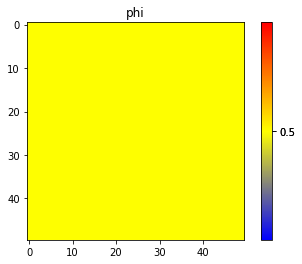

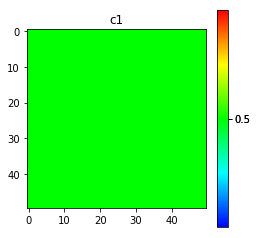

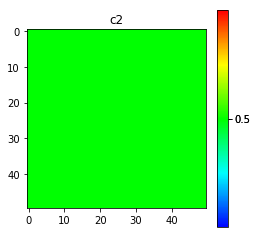

In [2]:
plotImages_c(phi, c1, c2)

In [3]:
#find noise
#standard deviation of noise in phi and c according to Kosterlitz and Grant paper
std_c1=np.absolute(np.sqrt(2*R*M_A*T/v_m))
std_c2=np.absolute(np.sqrt(2*R*M_B*T/v_m))
std_phi=np.absolute(np.sqrt(2*R*M_phi*T/v_m))
#random Gaussian generation via Box-Muller transform
r1=np.random.random((len(phi), len(phi[0])))
r2=np.random.random((len(phi), len(phi[0])))
th=np.random.random((len(phi), len(phi[0])))
#find random motion 
noise_c1_help=np.sqrt(-2*np.log(r1))*np.cos(2*np.pi*th)*std_c1
noise_c2_help=np.sqrt(-2*np.log(r1))*np.sin(2*np.pi*th)*std_c2
#bring into agreement with the energy functional
noise_c1=noise_c1_help-c1*noise_c1_help-c2*noise_c2_help
noise_c2=noise_c2_help-c1*noise_c1_help-c2*noise_c2_help    
noise_phi=np.sqrt(-2*np.log(r2))*np.sin(2*np.pi*th)*std_phi

#apply changes
c1 += (deltac1+noise_c1)*dt
c2 += (deltac2+noise_c2)*dt
phi += (deltaphi+noise_phi)*dt

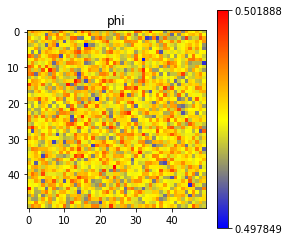

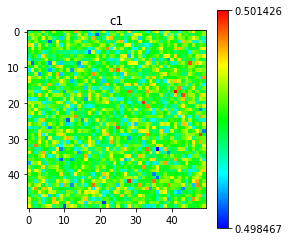

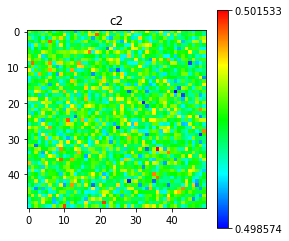

In [4]:
plotImages_c(phi, c1, c2)

### I.II. Adding Noise inside the functional
In this case, the noise in the concentration is added to the change in free energy with respect to concentration:

In [5]:
#standard deviation of noise in phi and c according to Kosterlitz and Grant paper
std_c1=np.sqrt(np.absolute(2*R*T/v_m))
#random Gaussian generation via Box-Muller transform
r1=np.random.random((len(phi), len(phi[0])))
r2=np.random.random((len(phi), len(phi[0])))
th=np.random.random((len(phi), len(phi[0])))
#find random motion 
noise_c1=np.sqrt(-2*np.log(r1))*np.cos(2*np.pi*th)*std_c1
noise_c2=np.sqrt(-2*np.log(r1))*np.sin(2*np.pi*th)*std_c1            

dFdc1 = (dGSdc1 + m*(dGLdc1-dGSdc1))/v_m + (W_A-W_C)*g*T + noise_c1
dFdc2 = (dGSdc2 + m*(dGLdc2-dGSdc2))/v_m + (W_B-W_C)*g*T + noise_c2

### I.III. Results

a) Noise outside the energy functional:
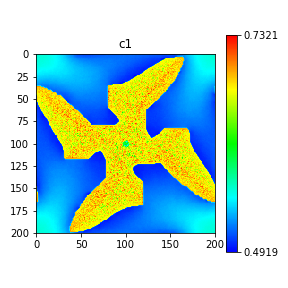
$$ Figure\_1$$

b) Noise inside the functional
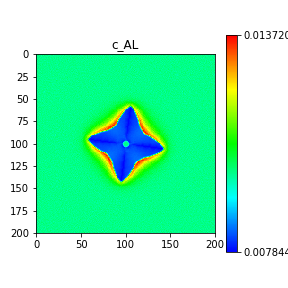
c) Old version of noise, same initial conditions and parameters used as Langevin noise inside functional
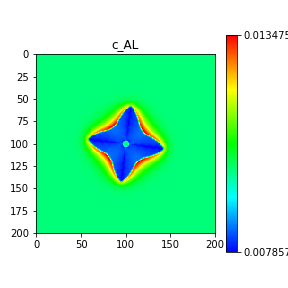
$$Figure\_2$$

## II. Brownian Motion in Spinodal Decomposition in the Context of Diffusion

The governing equation for determining the decomposition behavior is $$ 
F=\int_{V} \frac{\varepsilon}{2}|\nabla \varphi|^{2}+\varphi^{2}(1-\varphi)^{2} d V,
 $$
 which can be solved for the functional $$ 
f=2 \varphi-6 \varphi^{2}+4 \varphi^{3}-\varepsilon \nabla^{2} \varphi
 $$ This expression appears in the simulation code. The change in phase per time for a conserved approach is $$ 
\frac{d \varphi}{d t}=M \cdot \nabla^{2} f
 $$. An illustrative example is shown below for differnt amplitudes of Langevin noise added to the model.

In [6]:
## My simulation for conserved spinodal decompositon
def simulate(phi, m):
    #initial conditions & parameters
    M=0.25
    epsilon=0.25
    dt=0.025
    dx=1.
    inversexsq=1./(dx*dx) #write out functional and extract D from constant that shows up in from of (d/dx) term.
    laplacian=(np.roll(phi, 1, 0)+np.roll(phi, 1, 1)+np.roll(phi, -1, 0)+np.roll(phi, -1, 1)-4*phi)*inversexsq
    #find difference per timestep
    functional=phi*(2-phi*(6-4*phi))-epsilon*laplacian
    laplace_func=(np.roll(functional, 1, 0)+np.roll(functional, 1, 1)+np.roll(functional, -1, 0)+np.roll(functional, -1, 1)-4*functional)*inversexsq
    deltaphi=M*dt*laplace_func
    #standard deviation of noise and array generation, with a multiplication factor of m
    std=np.sqrt(2*M*m*300) #assume 300Kelvin for temperature
    r=np.random.random((len(phi), len(phi[0])))
    th=np.random.random((len(phi), len(phi[0])))
    noise=np.sqrt(-2*np.log(r))*np.cos(2*np.pi*th)*std*dt
    #update phi with noise
    phinew=phi+deltaphi+noise
    return phinew

### II.I. Demonstrating the Effect of altering Noise Amplitude
The line in the simulation that determines the noise amplitude is the equation finding the standard deviation. The ratio of the molar gas constant and the molar volume was assumed to be 1 for simplicity such that the distribution of the noise is $$\sigma=\sqrt{2Mm_iT}$$ where $T=300K$ and $m_i=10^{\frac{-i}{2}}$ is a multiplicative constant that allows to explore different levels of noise.

1 : new noise multiplication factor:  0.0001


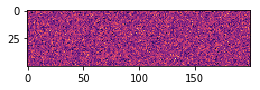

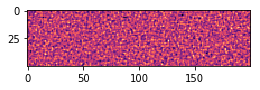

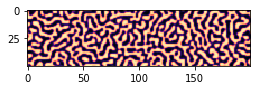

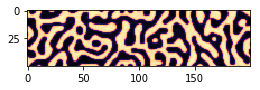

2 : new noise multiplication factor:  1e-05


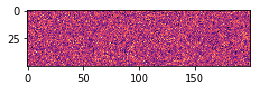

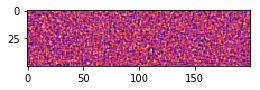

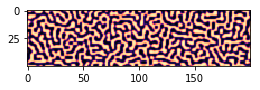

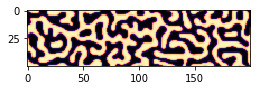

3 : new noise multiplication factor:  1e-06


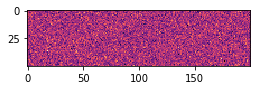

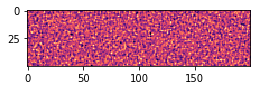

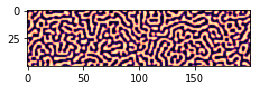

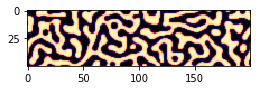

4 : new noise multiplication factor:  0.0


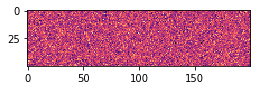

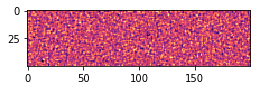

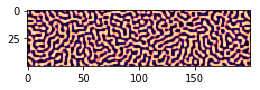

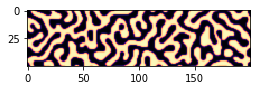

In [58]:
#create initial blank grid
grid0=np.full((50,200), 0.5)
for i in range (4,8):
    m_i=10**(-i/2)
    print(i-3,": new noise multiplication factor: ", round(m_i, 6))
    grid=simulate(grid0, m_i)
    #run simulations to compare different noise amplitudes
    for j in range(0,5):
        #only show select steps that are more spaced out as we progress
        for k in range(0, j**7):
            grid=simulate(grid, m_i)
        if (j!=1):
            plt.imshow(grid, cmap='magma')
            plt.show()
                

### II.II. Comparing the Amplitudes of Noise Flux and Flux expected from Diffusion
Fick's law of diffusion states that $$ 
\frac{d \varphi}{d t}=D \nabla^{2} \varphi
 $$
 where the transport of a species depends on the local gradient as well as on the diffusion constant. The following code investigates how the change in phase due to the noise term compares what is expected from Fick's law.

In [8]:
#===================================== FIND FLUXES 1D CASE ==============================
def find_expected_flux_x(grid, D, dx):
    #according to ficks law of diffusion
    return D*(np.roll(grid, -1, 0)+np.roll(grid, 1, 0)-2*grid)/(dx**2)

def add_noise(phi, m):
    #use the same approach to find the flux
    std=np.sqrt(2*m*M*300) #assume 300Kelvin for temperature
    r=np.random.random(len(phi))
    th=np.random.random(len(phi))
    noise=np.sqrt(-2*np.log(r))*np.cos(2*np.pi*th)*std
    return phi+noise

def find_time_flux_x(grid, dx, dt, m):
    grid2=add_noise(grid, m)
    return (grid2-grid)*dx/dt

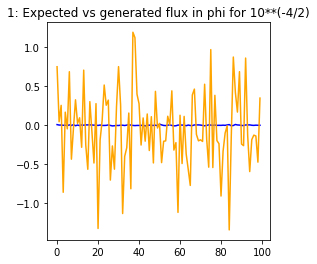

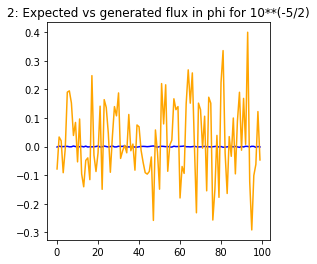

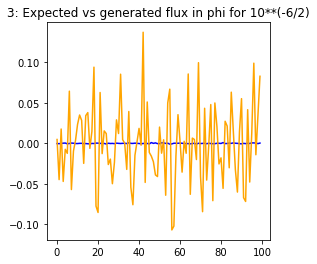

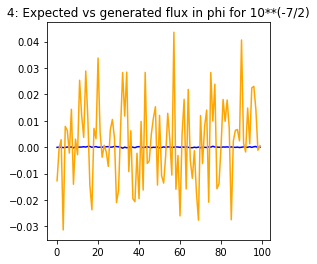

In [59]:
from matplotlib import rc
x=np.arange(0, 100, 1)
M=0.25 

for i in range (4,8):
    m_i=10**(-i/2)
    phi=np.full((100,100), 0.5)
    #use the case after one run of simulation as initial condition
    phi=simulate(phi, m_i)
    plt.figure()
    plt.plot(x, find_expected_flux_x(phi, 2*M, 1.)[0],label='expected', color='blue')
    plt.plot(x, find_time_flux_x(phi, 1., 0.25, m_i)[0],label='generated', color='orange')
    plt.title(str(i-3)+': Expected vs generated flux in phi for 10**(-'+ str(i)+'/2)')
    plt.show()

This example illustrates that ... (fix when D has been figured out)
Previous work comparing Brownian motion and Diffusion has made the argument that the expected transport of phase in Spinodal Decomposition should be a sum of the change driven by diffusion and the Brownian Motion Term.

## III. Stochastic Nucleation

This method of randomly introducing nuclei into the phase field is based on the thermodynamic probability of forming a nucleus above the critical number of molecules for stability. The proability follows a Poisson distribution:$$ 
P_{n}=1-\exp \left(-J^{0 *} \Delta t\right)
 $$ where $J^{0 *}=x_{1} \chi \exp \left(-\frac{x_{2}}{\Delta T}\right)$ and $\chi=\chi_{0} \exp \left(-\frac{Q}{R T}\right)$.
The code fragment I developed introduces a nucleus and then increases its radius. The nucleus needs to be added into the phase field as well as the orientation fields.
### Finding the nucleation probability

In [223]:
def find_Pn(T_M, T, Q ,dt):
    #finding the probability of forming a critical nucleus, nucleating only every 500 time steps
    #input: T_M -- temperature of the liquidus, T -- Temperature, Q -- activation energy for migration
    #choose free parameters
    a=10**28
    b=2.8*10**3
    J0=a*e**(-b/(T_M-T))*e**(-Q/(R*T))
    Pn=1-e**(-J0*dt*500)
    return J0,Pn

### Nucleation probability for binary Ni-10%mol Cu alloy
As a proof of concept, the result of the nucleation finding for the Ni-Cu alloy from reference was reproduced, shown below. 

C:\Users\Vera\Anaconda3\envs\vera\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys


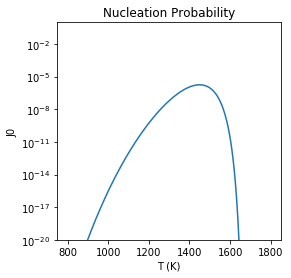

In [236]:
e=2.7182818284590452353
Q=8*10**5
Tm=1697
dt=10**(-6)
T=np.arange(800, 1800, 2)
y,p1=find_Pn(Tm, T, Q, dt)

plt.plot(T, y)
plt.yscale('log')
plt.title('Nucleation Probability')
plt.ylim(10**(-20),1)
plt.xlabel('T (K)')
plt.ylabel('J0')
plt.show()


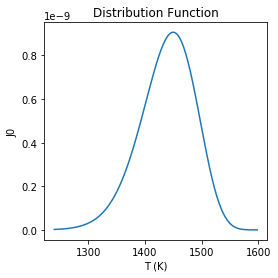

In [237]:
plt.plot(T[220:400], p1[220:400])
plt.title('Distribution Function')
plt.xlabel('T (K)')
plt.ylabel('J0')
plt.show()

In [238]:
def add_nuclei(phi, q1, q4, p11, size):
    random=np.random.random((size, size))
    nuclei_centers=np.argwhere(random<p11)
    print('number of nuclei added: ',len(nuclei_centers))
    for center in nuclei_centers:
        angle=np.random.random()
        for i in range((int)(center[0]-5), (int)(center[0]+5)):
            for j in range((int)(center[1]-5), (int)(center[1]+5)):
                if (i>=0 and i<size and j<size and j>=0):
                    if((i-center[0])*(i-center[0])+(j-center[1])*(j-center[1]) < 25):
                        if(phi[i][j]<0.2):
                            phi[i][j] = 1
                            q1[i][j] = np.cos(angle*2*np.pi)
                            q4[i][j] = np.sin(angle*2*np.pi)
    return phi, q1, q4
           

The value of J hereby affects the probability to nucleate, as well as the parameter b, which is a scaling factor that assures consistency with time and length scaling used in the model.
### Demonstration for J0 from the Nickel Copper

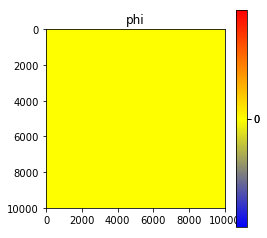

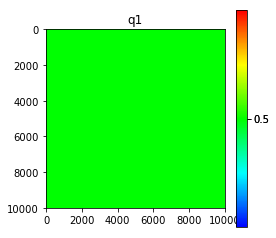

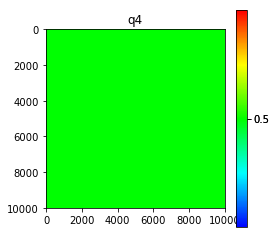

number of nuclei added:  1


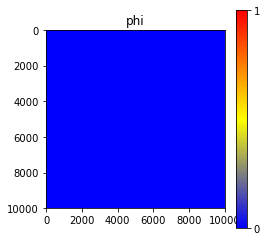

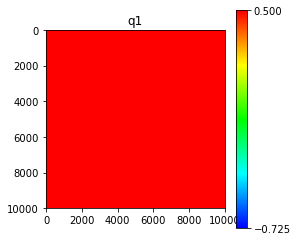

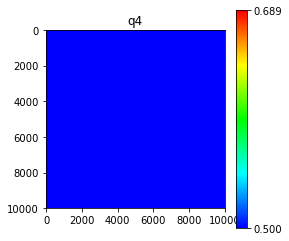

number of nuclei added:  0


In [250]:
dt=1
y1,p11=find_Pn(Tm, 1574, Q, dt)
size=10**3
phinew=np.full((size, size), 0)
q1new=np.full((size, size), 0.5)
q4new=np.full((size, size), 0.5)
for i in range(2):
    plotImages_q(phinew, q1new, q4new)
    phinew, q1new, q4new=add_nuclei(phinew,q1new,q4new, p11, 200)

## Demonstration for $p_{11}=10^{-2}$

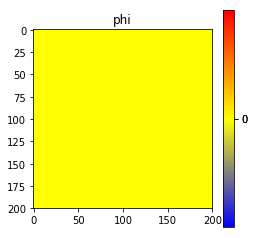

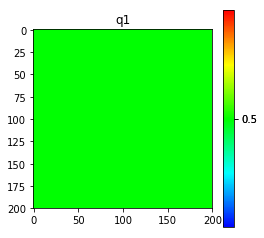

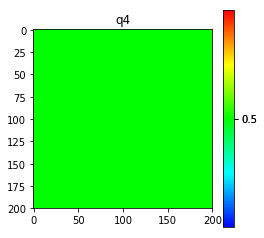

number of nuclei added:  392


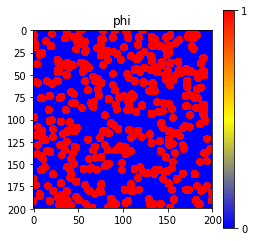

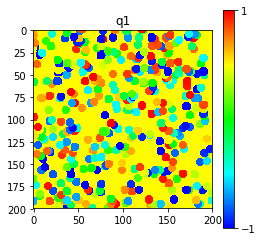

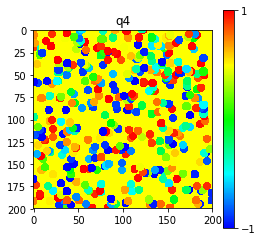

number of nuclei added:  405


In [258]:
size=200
phinew=np.full((size, size), 0)
q1new=np.full((size, size), 0.5)
q4new=np.full((size, size), 0.5)
for i in range(2):
    plotImages_q(phinew, q1new, q4new)
    phinew, q1new, q4new=add_nuclei(phinew,q1new,q4new, 10**(-2), 200)

## IV. Combined Approach
In the combined approach, every 100 iterations, a nucleation step is included. Executing this code made it obvious that my algorithm for stochastic nucleation is missing the quaternion component and all new nuclei have the same orientation.
### Illustrative example of inserting extra nuclei
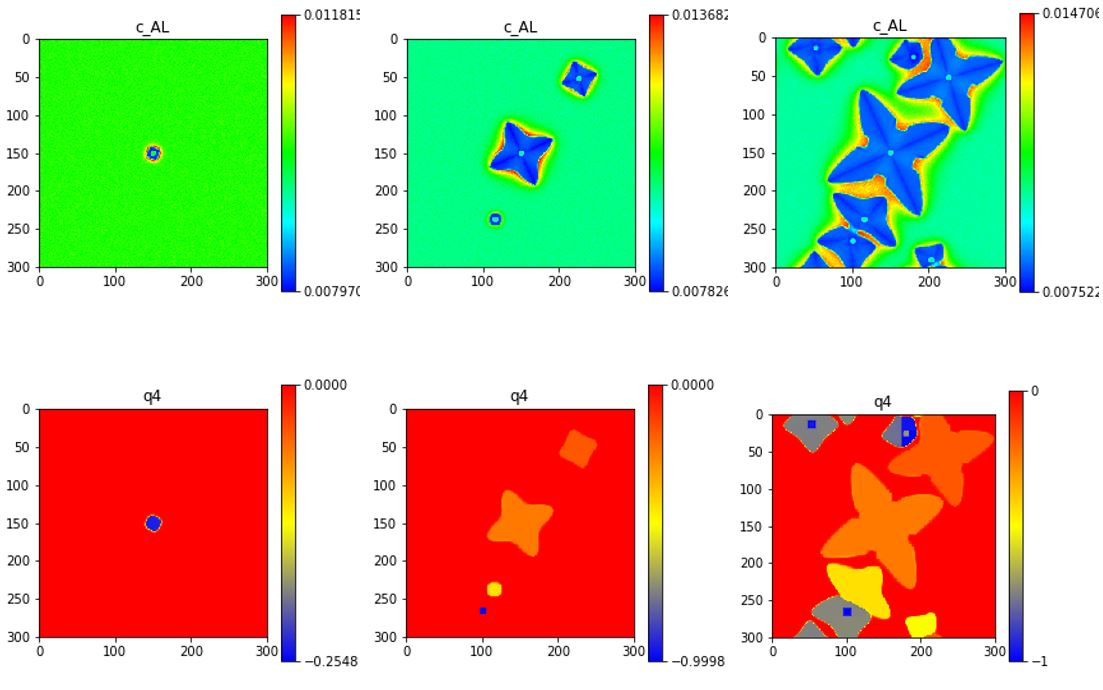
$$ Figure\_3$$

## V. Conclusions and Outlook (\# right now this is a To-Do-List)
- Test and Validate Langevin Model
- Find correct parameters for stochastic nucleation
- Figure out how to modify the quaternion when adding nuclei

## References
H. Cook. Brownian Motion in Spinodal Decomposition
http://jeti.uni-freiburg.de/studenten_seminar/term_paper_WS_18_19/Zwanzig01.pdf
https://www-sciencedirect-com.libproxy.rpi.edu/science/article/pii/S092702561830586X#b0175